### Importing data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install autocorrect

In [ ]:
pip install langdetect

In [ ]:
pip install langid

In [ ]:
pip install contractions

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import seaborn as sns
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from nltk.stem import PorterStemmer
from langdetect import detect
import langid
import contractions
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds

%matplotlib inline

### Uploading Data file

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/Data/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1')

In [ ]:
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
df.shape

(1599999, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column                                                                                                               Non-Null Count    Dtype 
---  ------                                                                                                               --------------    ----- 
 0   0                                                                                                                    1599999 non-null  int64 
 1   1467810369                                                                                                           1599999 non-null  int64 
 2   Mon Apr 06 22:19:45 PDT 2009                                                                                         1599999 non-null  object
 3   NO_QUERY                                                                                                             1599999 non-null  object
 4   _

In [ ]:
# create column name
column_names = ['target', 'id', 'data', 'flag', 'user', 'text']
df          = pd.read_csv('/content/drive/MyDrive/Data/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names = column_names)

In [ ]:
df['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [ ]:
# convert 4 to 1
df.replace({'target':{4:1}}, inplace=True)

In [ ]:
df.isnull().sum()

target    0
id        0
data      0
flag      0
user      0
text      0
dtype: int64

### Data Visualisation

In [ ]:
#checking the distribution of target column
df['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

In [ ]:
df['text_word_count']=df['text'].apply(lambda x:len(x.split()))

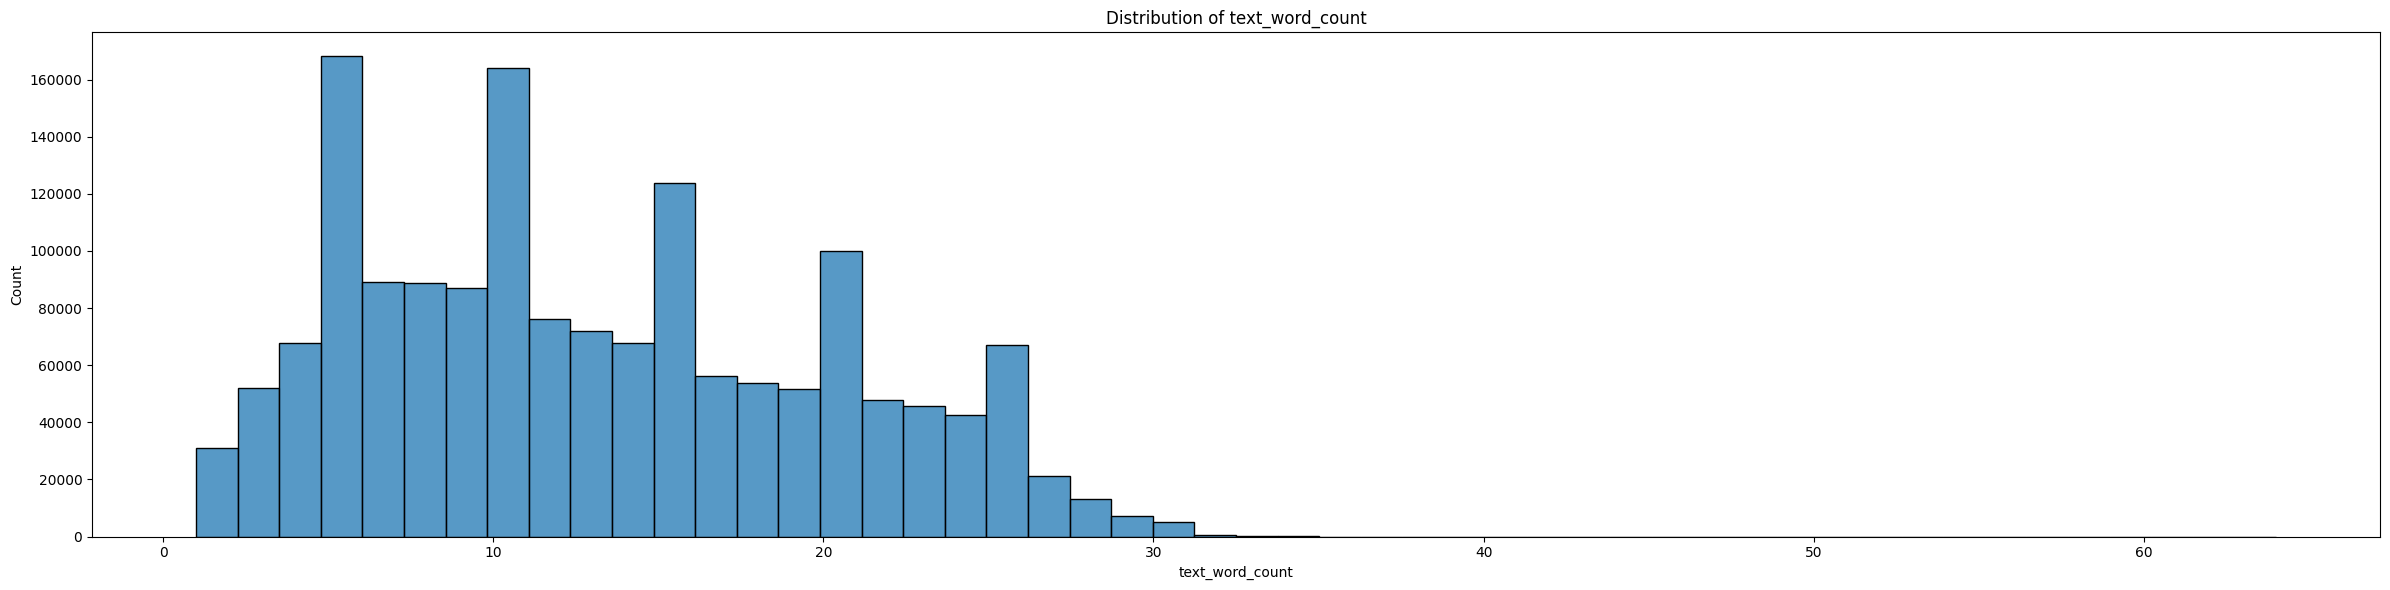

In [ ]:

num_cols = ['text_word_count']  # Ensure it's a list even if it's just one column
plt.figure(figsize=(24, 6))

for i, col in enumerate(num_cols):
  #  plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=col, bins=50)
    plt.title("Distribution of {}".format(col))

plt.tight_layout()
plt.show()


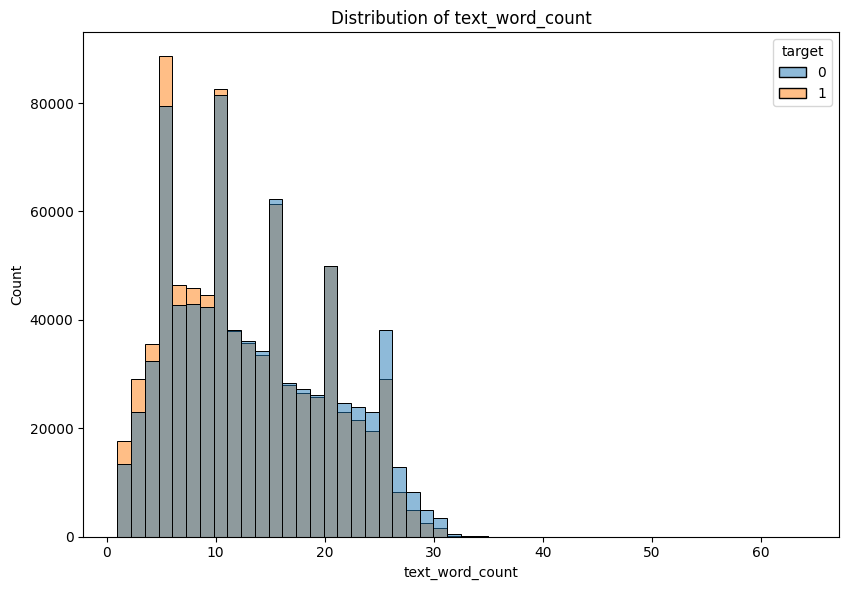

In [ ]:
num_cols = ['text_word_count']
plt.figure(figsize=(24,6))
for i,col in enumerate(num_cols):
    plt.subplot(1,3,i+1)
    sns.histplot(data=df,x=col,hue='target',bins=50)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

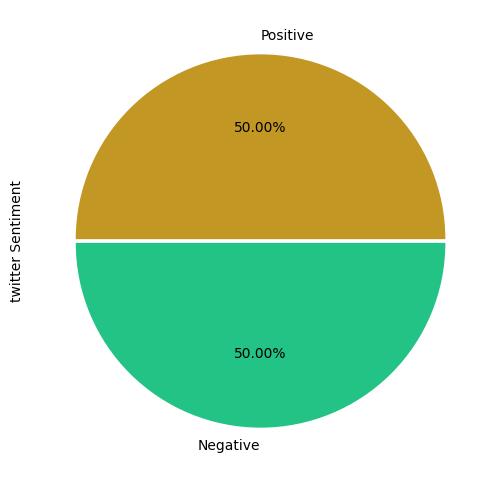

In [ ]:

plt.figure(figsize=(10,6))
colors=['#c29723','#23c285']
plt.pie(df['target'].value_counts(),labels=['Positive','Negative'],autopct='%.2f%%',explode=[0.01,0.01],colors=colors);
plt.ylabel('twitter Sentiment');

In [ ]:
X= df['text']
y= df['target']

In [ ]:
X.head()

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
Name: text, dtype: object

In [ ]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [ ]:
X.shape, y.shape

((1600000,), (1600000,))

### Text Data Preprocessing

In [ ]:
import re

def text_cleaning(text):
    # Step 1: Convert text to lowercase
    text = text.lower()

    # Step 2: Remove HTML tags
    text = re.sub(pattern=r'<.*?>', repl='', string=text)

    # Step 3: Remove URLs
    text = re.sub(pattern=r'http\S+|www\S+|ftp\S+', repl='', string=text)

    # Step 4: Remove 'rt'
    text = re.sub(pattern=r' rt', repl='', string=text)

    # Step 5: Remove words starting with '!'
    text = re.sub(pattern=r'!\S+', repl='', string=text)

    # Step 6: Remove mentions starting with '@'
    #text = re.sub(pattern=r'@\S+', repl='', string=text)

    # Step 7: Remove Unicode emojis
    text = re.sub(pattern=r'&#\d+;', repl='', string=text)

    text = re.sub(pattern=r'&amp', repl='', string=text)

    # Step 8: Remove '#' and '$'
    text = re.sub(pattern=r'#|\$', repl='', string=text)

    # Step 9: Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Step 10: Remove numeric digits
    text = re.sub(r'\d+', '', text)

    # Step 11: Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Step 12: Remove single characters
    text = re.sub(r'\b\w\b', '', text)

    # Step 13: Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [ ]:
X= X.apply(text_cleaning)

In [ ]:
print(type(X))

<class 'pandas.core.series.Series'>


In [ ]:
X[:5]

0    switchfoot thats bummer you shoulda got david ...
1    is upset that he cant update his facebook by t...
2    kenichan dived many times for the ball managed...
3       my whole body feels itchy and like its on fire
4    nationwideclass no its not behaving at all im ...
Name: text, dtype: object

Stop word removal

In [ ]:
def stopwords_removal(text):
    words= word_tokenize(text)
    stopword= set(stopwords.words('english'))
    filtered_text= [word for word in words if word.lower() not in stopword]
    return ' '.join(filtered_text)

In [ ]:
X= X.apply(stopwords_removal)
X[:5]

0    switchfoot thats bummer shoulda got david carr...
1    upset cant update facebook texting might cry r...
2    kenichan dived many times ball managed save re...
3                     whole body feels itchy like fire
4             nationwideclass behaving im mad cant see
Name: text, dtype: object

### Stemming

In [ ]:
def stemming(text):
    words= word_tokenize(text)
    stemmer= PorterStemmer()
    stemmed_text= [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_text)

In [ ]:
X1= X.apply(stemming)
X1[:5]

0    switchfoot that bummer shoulda got david carr ...
1    upset cant updat facebook text might cri resul...
2    kenichan dive mani time ball manag save rest g...
3                      whole bodi feel itchi like fire
4                nationwideclass behav im mad cant see
Name: text, dtype: object

In [37]:
X.head()

0    switchfoot thats bummer shoulda got david carr...
1    upset cant update facebook texting might cry r...
2    kenichan dived many times ball managed save re...
3                     whole body feels itchy like fire
4             nationwideclass behaving im mad cant see
Name: text, dtype: object

In [38]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf= TfidfVectorizer()
transformed_tf_idf= tf_idf.fit_transform(X1)

In [40]:
# Assuming tf_idf is your TF-IDF vectorizer
feature_names = tf_idf.get_feature_names_out()

# Display the first 10 items in the vocabulary
print(feature_names[:50])


['aa' 'aaa' 'aaaa' 'aaaaa' 'aaaaaa' 'aaaaaaa' 'aaaaaaaa' 'aaaaaaaaa'
 'aaaaaaaaaa' 'aaaaaaaaaaa' 'aaaaaaaaaaaa' 'aaaaaaaaaaaaa'
 'aaaaaaaaaaaaaa' 'aaaaaaaaaaaaaaa' 'aaaaaaaaaaaaaaaa'
 'aaaaaaaaaaaaaaaaaa' 'aaaaaaaaaaaaaaaaaaa' 'aaaaaaaaaaaaaaaaaaaa'
 'aaaaaaaaaaaaaaaaaaaaaaa' 'aaaaaaaaaaaaaaaaaaaaaaaaaa'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa' 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaah'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaah'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaargh'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaall' 'aaaaaaaaaaaaaaaaaaaaaaaaaargh'
 'aaaaaaaaaaaaaaaaaaaaaaah'
 'aaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh'
 'aaaaaaaaaaaaaaaaaaaaaaahrg' 'aaaaaaaaaaaaaaaaaaaaah'
 'aaaaaaaaaaaaaaaaaaaaahhhhh' 'aaaaaaaaaaaaaaaaaaaah'
 'aaaaaaaaaaaaaaaaaaaaint' 'aaaaaaaaaaaaaaaaaaaay' 'aaaaaaaaaaaaaaaaaah'
 'aaaaaaaaaaaaaaaaaahhhhh' 'aaaaaaaaaaaaaaaaaahh

In [41]:
transformed_tf_idf.shape

(1600000, 664737)

In [42]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(transformed_tf_idf,y,test_size=0.2)

In [43]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [44]:
y_pred = model.predict(X_test)

In [45]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [46]:
accuracy

0.758490625

In [47]:
### Prediction support

In [48]:
def predict_sentiment(sentence, model, feature_names):
    cleaned_sentence = clean_text(sentence) # clear sentence
    sentence_vectorized = feature_names.transform([cleaned_sentence]).toarray() # vectorize the sentence
    prediction = model.predict(sentence_vectorized) # to predict with use model
    return prediction

### Performance matrix

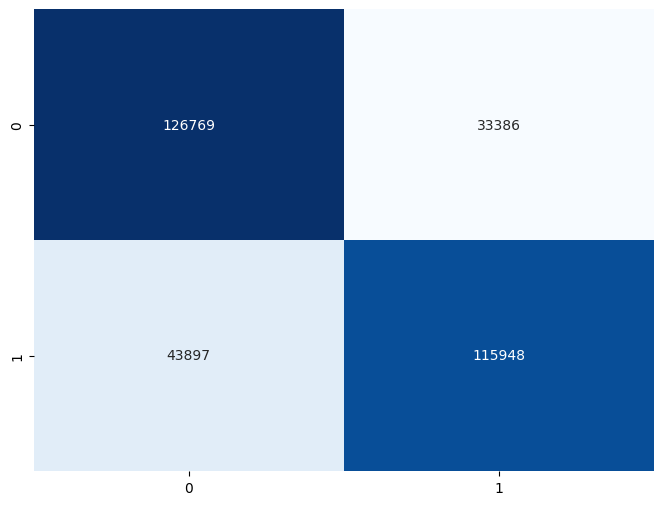

Accuracy: 0.758490625
              precision    recall  f1-score   support

           0       0.74      0.79      0.77    160155
           1       0.78      0.73      0.75    159845

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



In [49]:
# Model performansını görselleştirme
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.show()

print("Accuracy:", accuracy)

print(report)

### Bernouli NB model

In [50]:
from sklearn.naive_bayes import BernoulliNB

In [52]:
BNBmodel = BernoulliNB(alpha=2)
BNBmodel.fit(X_train, y_train)


BernoulliNB(alpha=2)

In [53]:
y_pred = model.predict(X_test)

In [54]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [55]:
accuracy

0.758490625

In [ ]:
### Prediction support

In [56]:
def predict_sentiment(sentence, model, feature_names):
    cleaned_sentence = clean_text(sentence) # clear sentence
    sentence_vectorized = feature_names.transform([cleaned_sentence]).toarray() # vectorize the sentence
    prediction = model.predict(sentence_vectorized) # to predict with use model
    return prediction

### Performance matrix

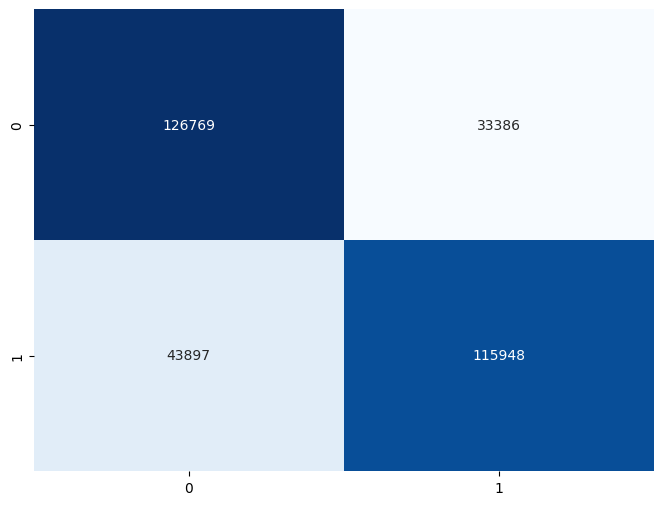

Accuracy: 0.758490625
              precision    recall  f1-score   support

           0       0.74      0.79      0.77    160155
           1       0.78      0.73      0.75    159845

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



In [62]:
# Model performansını görselleştirme
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.show()

print("Accuracy:", accuracy)

print(report)

In [63]:
from sklearn.linear_model import LogisticRegression


In [65]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [68]:
pred_train = classifier.predict(X_train)
pred_test  = classifier.predict(X_test)

print('Training Set Accuracy : ', accuracy_score(y_train, pred_train))
print('Testing Set Accuracy  : ', accuracy_score(y_test, pred_test))

Training Set Accuracy :  0.811840625
Testing Set Accuracy  :  0.781134375


In [70]:
classifier.predict(X_test[:10])

array([1, 0, 0, 1, 1, 0, 1, 1, 0, 0])

In [71]:
def predict_sentiment(x):
    preds = classifier.predict(x)
    for pred in preds:
        if pred == 0:
            print('Negative')
        else:
            print('Positive')

In [72]:
y_test[:10]

1400766    1
1314839    1
641042     0
1032019    1
131150     0
136447     0
330382     0
1043688    1
55691      0
528120     0
Name: target, dtype: int64

In [73]:
predict_sentiment(X_test[:10])

Positive
Negative
Negative
Positive
Positive
Negative
Positive
Positive
Negative
Negative


In this model Logistic regression performs better than multinomialNB, BernouliNB .
**Logistic regression**
Training Set Accuracy :  0.811840625
Testing Set Accuracy  :  0.781134375

Based on the results obtained from the Twitter sentiment analysis model, the following summary can be derived:

1. **Model Performance Comparison**: The performance of three different classifiers, namely Logistic Regression, Multinomial Naive Bayes (MultinomialNB), and Bernoulli Naive Bayes (BernoulliNB), was evaluated. Among these classifiers, Logistic Regression achieved the highest accuracy on both the training and testing datasets.

2. **Logistic Regression Performance**: Logistic Regression exhibited superior performance compared to the other classifiers. It achieved a training set accuracy of approximately 81.18% and a testing set accuracy of about 78.11%.

3. **Training vs. Testing Accuracy**: The model's performance on the training set (81.18% accuracy) is slightly higher than its performance on the testing set (78.11% accuracy). This indicates that the model may have slightly overfitted to the training data, as its performance slightly decreased when evaluated on unseen data. However, the drop in accuracy is relatively small, suggesting that the model generalizes well to unseen Twitter data.

4. **Implications**: The results suggest that Logistic Regression is a suitable classifier for sentiment analysis tasks on Twitter data, outperforming MultinomialNB and BernoulliNB. This information can be valuable for sentiment analysis applications, such as monitoring public opinion, customer feedback analysis, or brand sentiment tracking on social media platforms like Twitter.

5. **Further Investigation**: While Logistic Regression demonstrated the best performance in this evaluation, further investigation into feature engineering, hyperparameter tuning, and model optimization techniques could potentially enhance the performance of all classifiers. Additionally, exploring ensemble methods or deep learning approaches may also yield improved results for Twitter sentiment analysis tasks.